In [47]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize
from scipy.integrate import solve_ivp

In [48]:
# Загрузка данных
df = pd.read_csv("../data/d.csv")  # предполагая, что данные сохранены в этом файле
x_name, y_name, t_name = "population_1", "population_2", "year"

t_data = df[t_name].values
H_data = df[x_name].values
L_data = df[y_name].values

# Начальные условия из данных
y0 = [H_data[0], L_data[0]]


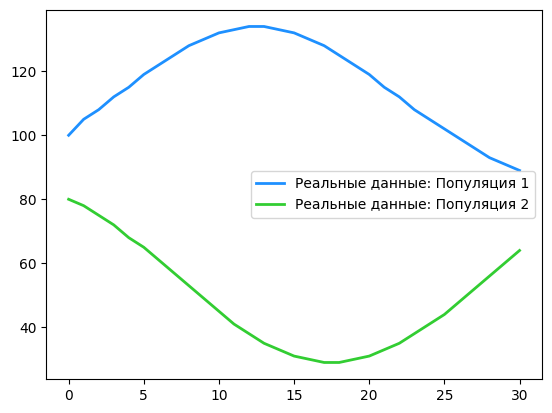

In [ ]:
plt.plot(
    df[t_name],
    df[x_name],
    "dodgerblue",
    label="Реальные данные: Популяция 1",
    zorder=2,
    linewidth=2,
)
plt.plot(
    df[t_name],
    df[y_name],
    "limegreen",
    label="Реальные данные: Популяция 2",
    zorder=2,
    linewidth=2,
)
plt.legend()
plt.show()

In [50]:
def objective(params):
    y_pred = solve_model(params, t_data, y0)
    error_H = np.mean((y_pred[0] - H_data) ** 2)
    error_L = np.mean((y_pred[1] - L_data) ** 2)
    return error_H + error_L


def solve_model(params, t, y0):
    r1, r2, a1, a2, b1, b2 = params

    def lotka_volterra(t, y):
        H, L = y
        dHdt = r1 * H - a1 * H * L - b1 * H * H
        dLdt = r2 * L - a2 * H * L - b2 * L * L
        return [dHdt, dLdt]

    solution = solve_ivp(lotka_volterra, [t[0], t[-1]], y0, t_eval=t, method="RK45")
    return solution.y


# Подбор параметров
initial_guess = np.random.random(size=6)
print("Начальное приближение:", initial_guess)

bounds = [(0.001, 5), (0.001, 5), (0.001, 2), (0.001, 2), (0.001, 2), (0.001, 2)]
result = minimize(objective, initial_guess, method="L-BFGS-B", bounds=bounds)
print("Найденные параметры:", result.x)

r1, r2, a1, a2, b1, b2 = result.x

Начальное приближение: [0.33385228 0.24741903 0.13861088 0.8617862  0.7419361  0.60882591]
Найденные параметры: [4.70832912e+00 4.70132715e+00 1.00000000e-03 3.87548267e-02
 3.99344174e-02 4.30845019e-03]


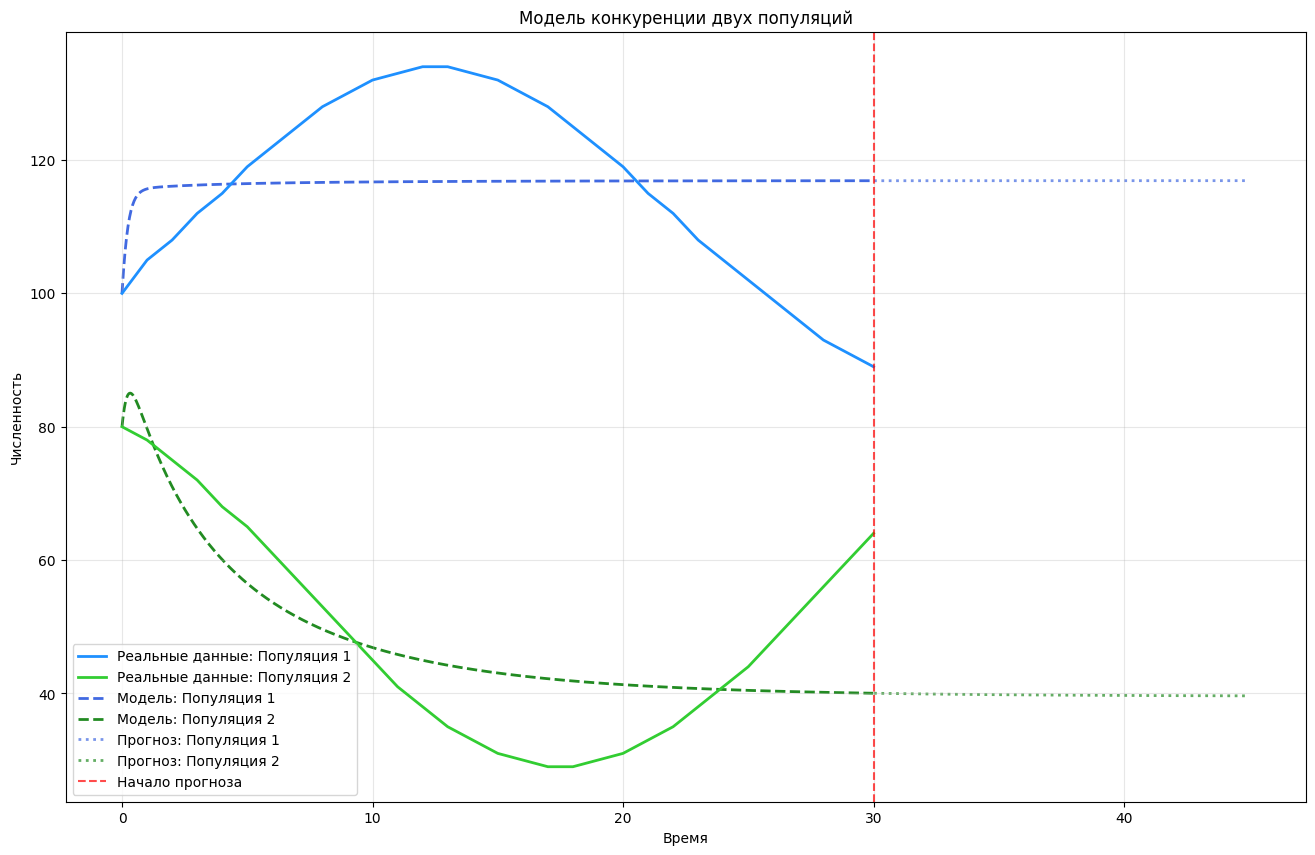

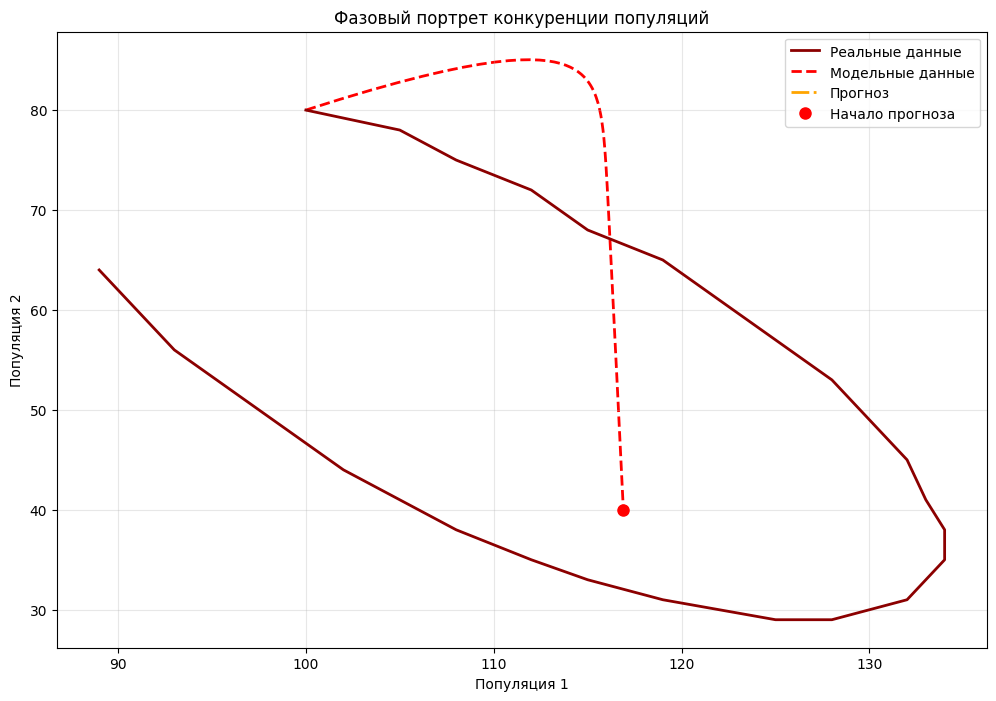


Интерпретация параметров:
r1 = 4.7083 - коэффициент роста популяции 1
r2 = 4.7013 - коэффициент роста популяции 2
a1 = 0.0010 - влияние популяции 2 на популяцию 1
a2 = 0.0388 - влияние популяции 1 на популяцию 2
b1 = 0.0399 - внутривидовая конкуренция популяции 1
b2 = 0.0043 - внутривидовая конкуренция популяции 2


In [51]:


def lotka_volterra_model(t, y):
    H, L = y
    dHdt = r1 * H - a1 * H * L - b1 * H * H
    dLdt = r2 * L - a2 * H * L - b2 * L * L
    return [dHdt, dLdt]


def runge_kutta_4th_order(f, y0, t_span, n_steps):
    t_start, t_end = t_span
    t = np.linspace(t_start, t_end, n_steps)
    h = (t_end - t_start) / (n_steps - 1)
    y = np.zeros((len(y0), n_steps))
    y[:, 0] = y0

    for i in range(n_steps - 1):
        k1 = h * np.array(f(t[i], y[:, i]))
        k2 = h * np.array(f(t[i] + h / 2, y[:, i] + k1 / 2))
        k3 = h * np.array(f(t[i] + h / 2, y[:, i] + k2 / 2))
        k4 = h * np.array(f(t[i] + h, y[:, i] + k3))
        y[:, i + 1] = y[:, i] + (k1 + 2 * k2 + 2 * k3 + k4) / 6

    return t, y


# Прогнозирование
H0 = df[x_name].iloc[0]
L0 = df[y_name].iloc[0]
n_steps = 1000
y0 = [H0, L0]

forecast_period = 1.5
t_max_original = df[t_name].iloc[-1]
t_min_original = df[t_name].iloc[0]
t_range_original = t_max_original - t_min_original

# Временной диапазон для прогноза
t_span_forecast = (t_min_original, t_min_original + t_range_original * forecast_period)
n_steps_forecast = int(n_steps * forecast_period)

# Вычисляем прогноз
t_forecast, y_forecast = runge_kutta_4th_order(
    lotka_volterra_model, y0, t_span_forecast, n_steps_forecast
)

# Разделяем данные на исторические и прогнозные
historical_mask = t_forecast <= t_max_original
forecast_mask = t_forecast > t_max_original

t_historical = t_forecast[historical_mask]
t_forecast_only = t_forecast[forecast_mask]
H_historical = y_forecast[0][historical_mask]
H_forecast = y_forecast[0][forecast_mask]
L_historical = y_forecast[1][historical_mask]
L_forecast = y_forecast[1][forecast_mask]

# Визуализация с прогнозом
plt.figure(figsize=(16, 10))

# Исторические данные
plt.plot(
    df[t_name],
    df[x_name],
    "dodgerblue",
    label="Реальные данные: Популяция 1",
    zorder=2,
    linewidth=2,
)
plt.plot(
    df[t_name],
    df[y_name],
    "limegreen",
    label="Реальные данные: Популяция 2",
    zorder=2,
    linewidth=2,
)

# Модель на историческом периоде
plt.plot(
    t_historical,
    H_historical,
    "royalblue",
    linestyle="--",
    label="Модель: Популяция 1",
    zorder=1,
    linewidth=2,
)
plt.plot(
    t_historical,
    L_historical,
    "forestgreen",
    linestyle="--",
    label="Модель: Популяция 2",
    zorder=1,
    linewidth=2,
)

# Прогноз
plt.plot(
    t_forecast_only,
    H_forecast,
    "royalblue",
    linestyle=":",
    alpha=0.7,
    label="Прогноз: Популяция 1",
    zorder=1,
    linewidth=2,
)
plt.plot(
    t_forecast_only,
    L_forecast,
    "forestgreen",
    linestyle=":",
    alpha=0.7,
    label="Прогноз: Популяция 2",
    zorder=1,
    linewidth=2,
)

# Вертикальная линия разделяющая историю и прогноз
plt.axvline(
    x=t_max_original, color="red", linestyle="--", alpha=0.7, label="Начало прогноза"
)

plt.legend()
plt.xlabel("Время")
plt.ylabel("Численность")
plt.title("Модель конкуренции двух популяций")
plt.grid(True, alpha=0.3)
plt.show()

# Фазовый портрет с прогнозом
plt.figure(figsize=(12, 8))

plt.plot(
    df[x_name], df[y_name], "darkred", label="Реальные данные", zorder=2, linewidth=2
)
plt.plot(
    H_historical,
    L_historical,
    "red",
    linestyle="--",
    label="Модельные данные",
    zorder=1,
    linewidth=2,
)
plt.plot(
    H_forecast,
    L_forecast,
    "orange",
    linestyle="-.",
    label="Прогноз",
    zorder=1,
    linewidth=2,
)

# Точка начала прогноза
plt.plot(
    H_historical[-1], L_historical[-1], "ro", markersize=8, label="Начало прогноза"
)

plt.legend()
plt.xlabel("Популяция 1")
plt.ylabel("Популяция 2")
plt.title("Фазовый портрет конкуренции популяций")
plt.grid(True, alpha=0.3)
plt.show()

# Вывод найденных параметров для интерпретации
print("\nИнтерпретация параметров:")
print(f"r1 = {r1:.4f} - коэффициент роста популяции 1")
print(f"r2 = {r2:.4f} - коэффициент роста популяции 2")
print(f"a1 = {a1:.4f} - влияние популяции 2 на популяцию 1")
print(f"a2 = {a2:.4f} - влияние популяции 1 на популяцию 2")
print(f"b1 = {b1:.4f} - внутривидовая конкуренция популяции 1")
print(f"b2 = {b2:.4f} - внутривидовая конкуренция популяции 2")